# Sklearn
1. Main Python ML library
2. Has numerous features to assist on all steps of the pipeline

In [4]:
import root_pandas
import numpy as np

In [8]:
data = root_pandas.read_root("/notebooks/public_train_10000.root")
features = data[list(set(data.columns) - {"event_id", "target"})]
target = data["target"]

## KNN

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

In [35]:
cv_score = list()
for i in range(10):
    trainX, testX, trainY, testY = train_test_split(features, target, random_state=i)
    cv_score.append(np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=1), trainX, trainY, scoring='roc_auc', n_jobs=4, cv=4)))

In [36]:
cv_score

[0.60454439728338838,
 0.61790066300841229,
 0.61127394255094436,
 0.61281485973017413,
 0.61735042735042733,
 0.61498958882332233,
 0.61041987673343612,
 0.6121380561374874,
 0.61244166049905258,
 0.62396134568287276]

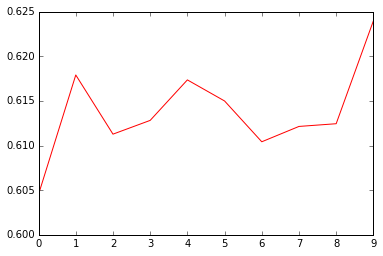

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(10), cv_score, '-r')

In [9]:
knn_clf = KNeighborsClassifier(n_neighbors=1)
knn_clf.fit(trainX, trainY)
roc_auc_score(testY, knn_clf.predict_proba(testX)[:, 1])

0.62039587934568208

How will this compare to cross validation?

In [10]:
cv_scores = cross_val_score(
    KNeighborsClassifier(n_neighbors=1), features, target, scoring='roc_auc', n_jobs=4, cv=4)

In [11]:
np.mean(cv_scores), np.std(cv_scores)

(0.61592131519412685, 0.0077340089103426265)

**Exercise 0**. How stable is validation using train_test_split compared to cross validation? Use different random seeds for train_test_split and plot the distribution of scores.

In [14]:
def get_mean_cross_val_score(estimator, X, Y, *args, **kwargs):
    """Returns the mean cross validtion score and its standart deviation"""
    cv_scores = cross_val_score(estimator, X, Y, *args, **kwargs)
    return (np.mean(cv_scores), np.std(cv_scores))

Increasing the number of neighbours yields an improvement. 

In [15]:
get_mean_cross_val_score(KNeighborsClassifier(n_neighbors=10, p= 3), features, target, scoring='roc_auc', n_jobs=4, cv=4)

(0.72205637475411921, 0.0064299537459681574)

**Exercise 1.** Try different distance metrics for KNN 0 find the best one.

## Decision tree

In [2]:
from sklearn.tree import DecisionTreeClassifier

One of the few advantages of the decision tree is its interpretability

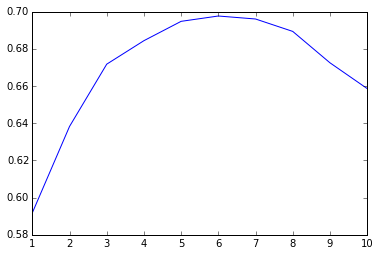

In [17]:
tree = DecisionTreeClassifier(max_depth=3).fit(features, target)
validation_score = list()
for i in range(10):
    tree = DecisionTreeClassifier(max_depth=i + 1).fit(features, target)
    validation_score.append(get_mean_cross_val_score(tree, features, target, scoring='roc_auc', n_jobs=4, cv=4)[0])
    
plt.plot(range(1, 11), validation_score)

In [64]:
list(tree.feature_importances_).index(max(tree.feature_importances_))
tree.feature_importances_

array([ 0.03908256,  0.02679735,  0.07026433,  0.01889634,  0.03832675,
        0.02204103,  0.0236637 ,  0.02642152,  0.00679809,  0.05476825,
        0.06987625,  0.03137108,  0.00608527,  0.02172745,  0.00260272,
        0.04853709,  0.09312342,  0.01004894,  0.03238976,  0.20980097,
        0.03500025,  0.01023566,  0.00850198,  0.02848606,  0.02182924,
        0.0128245 ,  0.02002793,  0.01047152])

In [88]:
sorted_importance = list()
for i in range(len(list(tree.feature_importances_))):
    sorted_importance.append((tree.feature_importances_[i], i))
sorted_importance = sorted(sorted_importance, key=lambda x: -x[0])
importance_validation_score = list()
numbers_list = [x[1] for x in sorted_importance]



In [94]:
for i in range(len(list(tree.feature_importances_))):
    tree = DecisionTreeClassifier(max_depth=6).fit(features[:][numbers_list[:i+1]], target)
    importance_validation_score.append(get_mean_cross_val_score(tree, features[:][numbers_list[:i+1]], target, scoring='roc_auc', n_jobs=4, cv=4)[0])

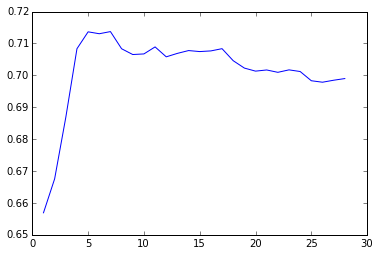

In [95]:
plt.plot(range(1, 29), importance_validation_score)

**Exercise 2.** Plot cross validation score of a DecisionTreeClassifier as a function of max_depth.

## Linear regression + Ridge regularization¶

In [47]:
from sklearn.linear_model import Ridge

ridge_clf = Ridge()
ridge_clf.fit(trainX, trainY)
print roc_auc_score(testY, ridge_clf.predict(testX))
print roc_auc_score(trainY, ridge_clf.predict(trainX))

0.681684732426
0.675638178257


In [48]:
alpha = np.logspace(-5,10,20)
train_score = list()
test_score = list()

for i in alpha:
    ridge_clf = Ridge(alpha = i)
    ridge_clf.fit(trainX, trainY)
    test_score.append(roc_auc_score(testY, ridge_clf.predict(testX)))
    train_score.append(roc_auc_score(trainY, ridge_clf.predict(trainX)))

In [51]:
train_score

[0.67563953345719396,
 0.67563953345719396,
 0.67563953345719396,
 0.67563949779401855,
 0.67563928381496696,
 0.67563906983591515,
 0.67563792861430594,
 0.6756422081953406,
 0.67566563890150577,
 0.67570879134360584,
 0.67574024626421114,
 0.67535647483492234,
 0.67424956120029123,
 0.67323276840961643,
 0.67194596971882581,
 0.66549885221636651,
 0.63169287244337835,
 0.58629714529120558,
 0.57205958546266267,
 0.56934533251774033]

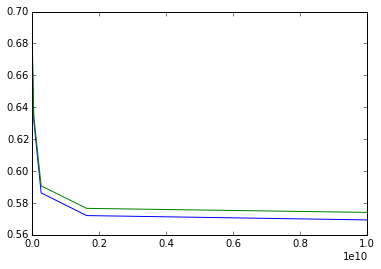

In [50]:
plt.plot(alpha, train_score)
plt.plot(alpha, test_score)

**Exercise 3.** Plot how regularization parametera alpha of RidgeClassifier, affects quality on train and test.

**Exercise 4.** Find the most important features for Decision tree - use feature\_importances_ . Verify whether they make sense. Take first N features by importance, cross-validate the Decision tree, plot the dependance of the score on N. Alternative

Many thanks to Alexey and Tatiana for the materials inspiraiton.